In [1]:
!pip install keras -tuner
!pip install -q keras

     |████████████████████████████████| 14.5MB 234kB/s 
     |████████████████████████████████| 2.9MB 49.6MB/s 
     |████████████████████████████████| 25.9MB 123kB/s 
     |████████████████████████████████| 276kB 53.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=c6d73f85c5e1c3678168d5a97d800bf45b5607724d2286eb95cd12164c5147b3
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built pyyaml
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.5.2 which is incompatible.
ERROR: nbclient 0.5.0 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has

In [2]:
# memory footprint support libraries/code

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed

gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 


  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=a31423622faaa48c0eb6f8a6fedfafbca24bf484333dc26823f6b3a7eda971b6
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 115.0 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [3]:
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil

try:
  import GPUtil as GPU
  GPUs = GPU.getGPUs()
  device='/gpu:0'
except:
  device='/cpu:0'

In [4]:
%tensorflow_version 2.x

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Import all libraries

import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import VGG19

In [8]:
# reading text files

all_df = pd.read_csv("/content/drive/My Drive/JF30-22/classlabels.txt", header = None, dtype=str)
all_df.columns = ['id', 'label']
#all_df.head(2)

trn1 = pd.read_csv('/content/drive/My Drive/JF30-22/trn1.txt', header = None, dtype=str)
trn1.columns = ['id']
#trn1.head(2)

val1 = pd.read_csv('/content/drive/My Drive/JF30-22/val1.txt', header = None, dtype=str)
val1.columns = ['id']
#trn1.head(2)

tst1 = pd.read_csv('/content/drive/My Drive/JF30-22/tst1.txt', header = None, dtype=str)
tst1.columns = ['id']
#tst1.head(2)

In [9]:
# merge data (id and label)

train_data= pd.merge(all_df, trn1)
val_data= pd.merge(all_df, val1)
data = pd.merge(all_df, tst1)
test_data = data.append(val_data)

# VGG-19 Model

In [10]:
#Training data with augmentation

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.10,
      height_shift_range=0.10,
      zoom_range = 0.1,
      brightness_range=[0.2,0.8],
     # np.clip(x_channel + np.random.uniform(-value, value), min_img, max_img) for x_channel in img,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Data Generator for Validation Data

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data, 
    directory="/content/drive/My Drive/JF30-22/train/",
    x_col="id",
    y_col="label",
    #subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

''' Data Generator for Validation Data

val_generator = train_datagen.flow_from_dataframe(
    dataframe = val_data, 
    directory="/content/drive/My Drive/JF30-22/valid/",
    x_col="id",
    y_col="label",
    #subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))'''

# Data Generator for Training Data

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data, 
    directory="/content/drive/My Drive/JF30-22/test/",
    x_col="id",
    y_col="label",
    #subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

Found 921 validated image filenames belonging to 30 classes.
Found 558 validated image filenames belonging to 30 classes.


In [19]:
vgg_conv = VGG19(weights='imagenet', include_top=False, input_shape=(64,64,3))
  
for layer in vgg_conv.layers[:-4]:
  layer.trainable = False

model = Sequential()

model.add(vgg_conv)
model.add(BatchNormalization())
model.add(Dropout(0.5))
  
model.add(Flatten())
model.add(BatchNormalization())
  
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
  
model.add(Dense(30, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
batch_normalization_3 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)              

In [20]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#early_stop = EarlyStopping(monitor='val_loss',patience=5)
Model = model.fit_generator(
    train_generator, 
    steps_per_epoch =train_generator.samples/train_generator.batch_size , 
    epochs=50, 
    validation_data = test_generator,
    validation_steps = test_generator.samples/test_generator.batch_size,
    verbose=1)

Epoch 1/50
29/28 [==============================] - 27s 947ms/step - loss: 4.3697 - accuracy: 0.0413 - val_loss: 47.2140 - val_accuracy: 0.0358
Epoch 2/50
29/28 [==============================] - 27s 927ms/step - loss: 4.0129 - accuracy: 0.0760 - val_loss: 25.8303 - val_accuracy: 0.0358
Epoch 3/50
29/28 [==============================] - 27s 924ms/step - loss: 3.3388 - accuracy: 0.1314 - val_loss: 15.7256 - val_accuracy: 0.0645
Epoch 4/50
29/28 [==============================] - 27s 924ms/step - loss: 2.9743 - accuracy: 0.2085 - val_loss: 8.1884 - val_accuracy: 0.0789
Epoch 5/50
29/28 [==============================] - 27s 932ms/step - loss: 2.5350 - accuracy: 0.2660 - val_loss: 6.0453 - val_accuracy: 0.1147
Epoch 6/50
29/28 [==============================] - 27s 929ms/step - loss: 2.3066 - accuracy: 0.3062 - val_loss: 4.2143 - val_accuracy: 0.2563
Epoch 7/50
29/28 [==============================] - 27s 932ms/step - loss: 2.1367 - accuracy: 0.3561 - val_loss: 17.4839 - val_accuracy: 0.

In [21]:
# Model Evaluation

print("Minimum loss", min(Model.history['val_loss']))
print("Maximum loss", max(Model.history['val_loss']))
print("Accuracy", max(Model.history['accuracy']))
print("Val_Accuracy", max(Model.history['val_accuracy']))

Minimum loss 0.5852563381195068
Maximum loss 195.72964477539062
Accuracy 0.834962010383606
Val_Accuracy 0.8118279576301575


In [22]:
# Plot the accuracy and loss curves

losses = pd.DataFrame(model.history.history)
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,4.369651,0.041260,47.214001,0.035842
1,4.012873,0.076004,25.830296,0.035842
2,3.338794,0.131379,15.725596,0.064516
3,2.974296,0.208469,8.188437,0.078853
4,2.535048,0.266015,6.045295,0.114695


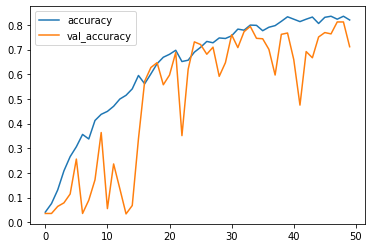

In [23]:
losses[['accuracy','val_accuracy']].plot()

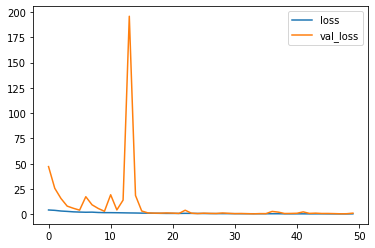

In [24]:
losses[['loss','val_loss']].plot()

CNN Model is created using fine tuning of VGG19 Model

In VGG19 model, only last 4 layers are made trainable

FRom both the plots we can observe that there is lot of noise in the plot.

From the Accuary plot, we can observe that Train and Validation accuracy has been increasing throughout the epochs. Training accuray reaches upto 83% whereas the validation accuracy is ~81%.

From the Loss plot also we can see that there was initially high validation error but later it smoothen out.

Overall this fine tuning model is performing very well with having accuracy of 81% which is really good as compared to the model we created fromscratch (having accuracy 59%)